<a href="https://colab.research.google.com/github/codewithlax/transfer-learning/blob/main/Transfer_learning_for_cats_%26_dogs_for_Mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [ ]:
# Using the MobileNet model as it is:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3)) # 3 reperents that it is a color image (RGB)
])

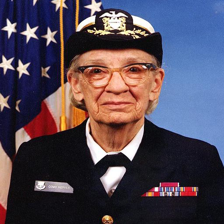

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [ ]:
# Normalizing pixel values to be in the 0 to 1 range
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 9s 9s/step


(1, 1001)

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

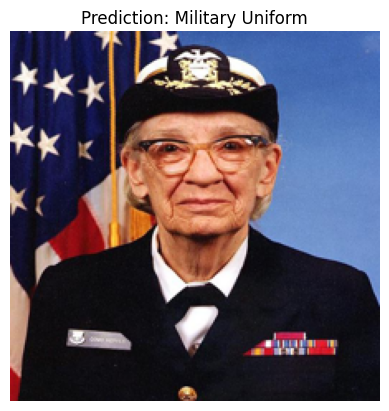

In [ ]:
# Figuring out what that corresponding label is:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

**Cats Vs Dogs now!**

In [ ]:
import tensorflow_datasets as tfds
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [ ]:
# Checking the image size of random cats and dogs:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [ ]:
# Because MobileNet expects 224, 224 as input shape, we need to convert our data to the same:
def format_image(image, label):
  image = tf.image.resize(image,(IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

print("Image batch: {} and Label batch: {}".format(image_batch, label_batch))

Image batch: [[[[0.8689076  0.8532213  0.664986  ]
   [0.8635154  0.8478291  0.6595938 ]
   [0.85984886 0.8444777  0.65529704]
   ...
   [0.7097602  0.6979955  0.4901523 ]
   [0.71275455 0.70098984 0.49314675]
   [0.7193888  0.7076241  0.49978092]]

  [[0.8507258  0.83503956 0.6468043 ]
   [0.84202766 0.8263414  0.6381061 ]
   [0.8392997  0.82392853 0.63474786]
   ...
   [0.698083   0.6863183  0.47847515]
   [0.6869573  0.68303573 0.47127104]
   [0.69571084 0.69178927 0.48002458]]

  [[0.85774803 0.84206176 0.6538265 ]
   [0.85188204 0.83619577 0.6479605 ]
   [0.84943104 0.8340599  0.6448792 ]
   ...
   [0.7019608  0.6901961  0.48235294]
   [0.6974003  0.6934787  0.48171395]
   [0.70615375 0.7022322  0.4904675 ]]

  ...

  [[0.13912895 0.13294134 0.07009904]
   [0.16190235 0.15779343 0.08320858]
   [0.21060544 0.20203285 0.1137744 ]
   ...
   [0.75686276 0.8862745  0.5444678 ]
   [0.7488322  0.87824404 0.5292244 ]
   [0.7510303  0.8804421  0.53142244]]

  [[0.11390022 0.10605708 0.0565

In [ ]:
result_batch = model.predict(image_batch)

result_batch

1/1 [==============================] - 1s 654ms/step


array([[ 0.27344254, -0.6751563 , -0.25467283, ..., -0.18880415,
        -0.68532974,  2.7868774 ],
       [ 0.1461767 , -0.88770556, -0.35480762, ...,  0.0468687 ,
         0.88922143,  1.3173989 ],
       [ 0.09433231, -0.14605549,  0.35637498, ..., -1.5947834 ,
         0.6711648 , -0.83196247],
       ...,
       [ 0.23382035, -1.0692962 ,  0.62271476, ...,  0.06880923,
        -2.3751414 , -0.39854768],
       [ 0.19017145,  0.6805544 ,  1.274794  , ..., -1.3495597 ,
         1.4509014 ,  0.69466347],
       [ 0.30311516,  1.6324723 ,  1.1801728 , ..., -1.7702714 ,
         0.9271996 ,  0.12036024]], dtype=float32)

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['tabby', 'tabby', 'Border collie', 'Labrador retriever',
       'tiger cat', 'Chihuahua', 'Border collie', 'Rottweiler',
       'bluetick', 'Walker hound', 'Persian cat', 'tabby', 'tiger cat',
       'Labrador retriever', 'miniature pinscher', 'Labrador retriever',
       'black-and-tan coonhound', 'kelpie', 'Siamese cat', 'Persian cat',
       'Labrador retriever', 'schipperke', 'dalmatian', 'kelpie',
       'tiger cat', 'Irish wolfhound', 'Persian cat', 'tabby',
       'American Staffordshire terrier', 'Great Dane', 'tabby',
       'Egyptian cat'], dtype='<U30')

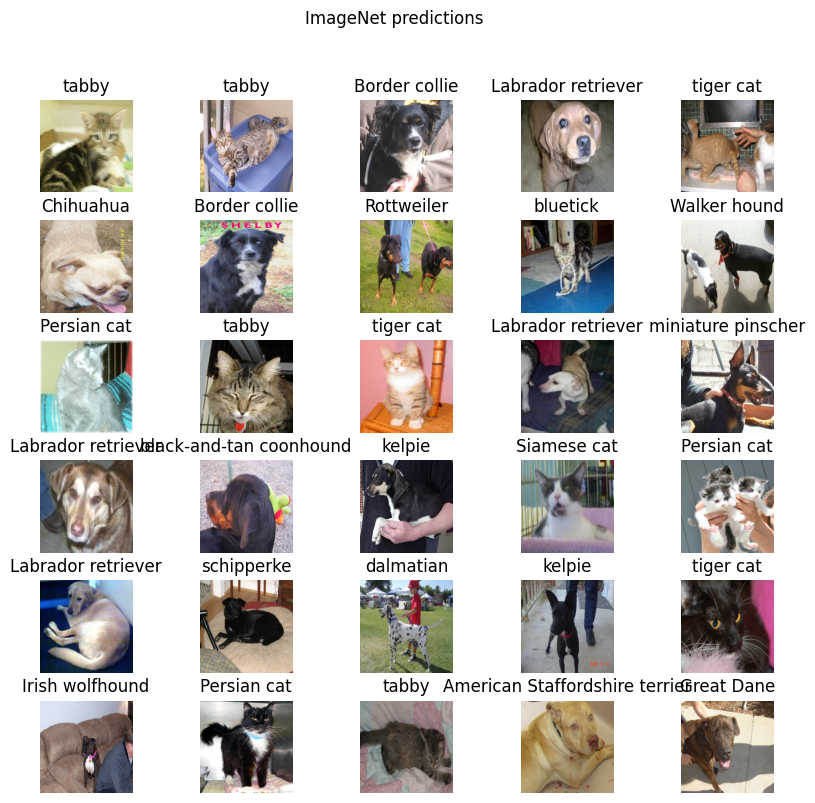

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")
# This is because MobileNet already has a lot of cats and dogs trained with more specifics

In [ ]:
# We use the hub module bacause it has got features to extract all the layers from the established model, except for the final classification layer:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


The above result indicates that the model accepts 32 inputs. 1280 is the number of nodes in the current final layer, on top of which, we will add our final custom output layer

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 3
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
582/582 [==============================] - 45s 62ms/step - loss: 0.0577 - accuracy: 0.9800 - val_loss: 0.0335 - val_accuracy: 0.9884
Epoch 2/3
582/582 [==============================] - 41s 62ms/step - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.0313 - val_accuracy: 0.9899
Epoch 3/3
582/582 [==============================] - 43s 64ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.0320 - val_accuracy: 0.9897


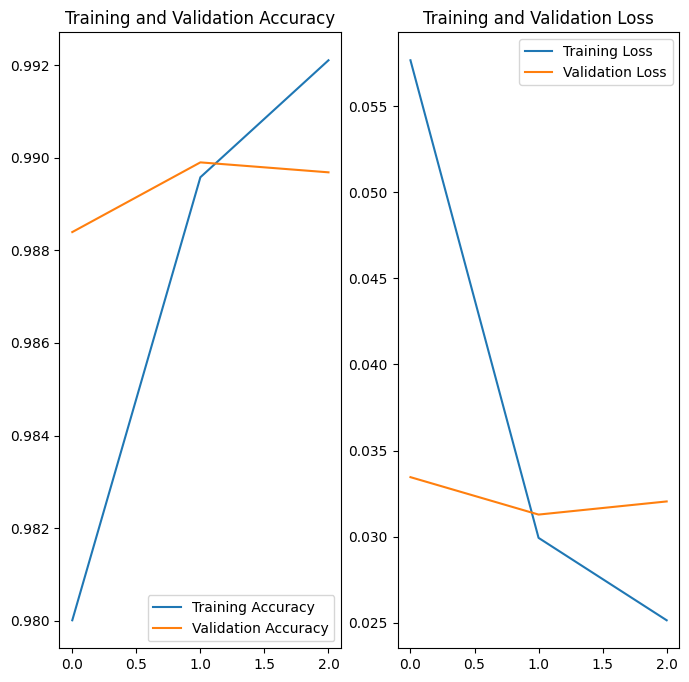

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 1s/step


array(['cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog',
       'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat',
       'cat', 'dog', 'dog', 'cat', 'cat'], dtype='<U3')

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0]
Predicted labels:  [0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0]


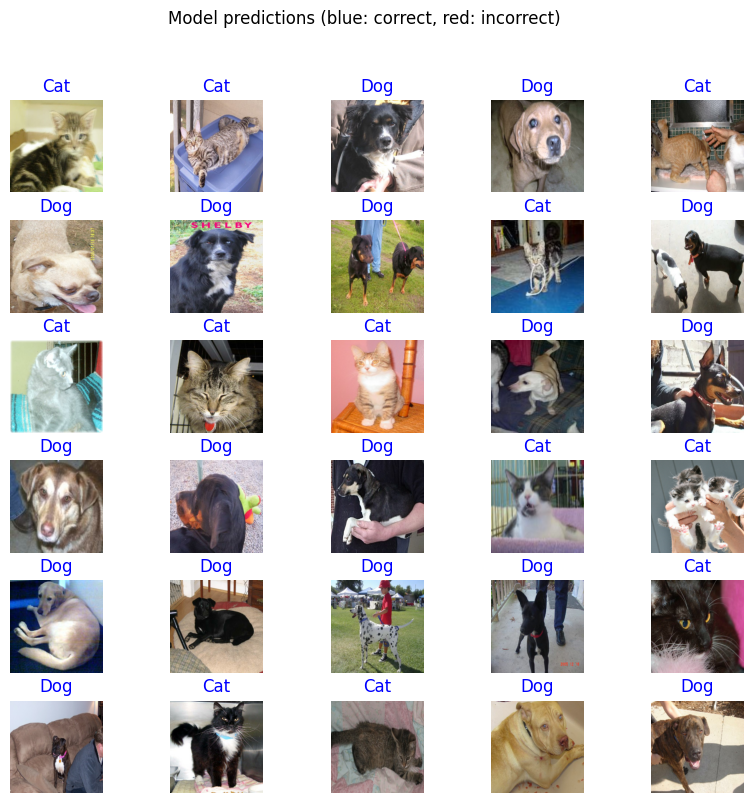

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")